# ViT on Caltech Football Numbers (CaltechFN) + 5-Fold Group Cross-Validation

We train a **Vision Transformer (ViT)** for **digit classification** on **Caltech Football Numbers**.
We use the **full-image COCO annotations** (`train.json`, `test.json`) and create a classification dataset by **cropping digit bounding boxes**.

Key features:
- Central configs for different architectures (`Cfg`) controlling everything
- AdamW with **decay/no-decay parameter groups**
- Step-based **logging** (`log_interval`) and **validation** (`val_interval`, `val_batches`)
- Hyperparameter search with saving **best checkpoint** (by val accuracy)
- **5-fold Group CV** for the best 2 architectures: split by **image_id** to avoid leakage across crops
- Final train for the best architecture extracted from CV and evaluation on the test set
- Summary table across folds + plots

In [4]:
import os, math, time, random, json
from dataclasses import dataclass, asdict
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset

import torchvision
from torchvision import transforms
from PIL import Image

In [5]:
def seed_everything(seed: int = 1337):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_everything(1337)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Configs for all Architectures

In [6]:
@dataclass
class Cfg:
    name: str = ""
    img_size: int = 96
    min_box_size: int = 8
    batch_size: int = 128
    num_workers: int = min(8, os.cpu_count() or 2)
    val_frac: float = 0.1

    mean = (0.485, 0.456, 0.406)
    std  = (0.229, 0.224, 0.225)

    patch_size: int = 0
    embed_dim: int = 0
    depth: int = 0
    num_heads: int = 0
    mlp_ratio: float = 0.0
    drop: float = 0.0
    attn_drop: float = 0.0

    epochs: int = 8
    lr: float = 3e-4
    min_lr: float = 1e-6
    warmup_epochs: int = 1
    weight_decay: float = 0.05
    grad_clip: float = 1.0

    log_interval: int = 50
    val_interval: int = 500
    val_batches: int = 30

    k_folds: int = 5
    seed: int = 1337

    data_dir: str = "./data/caltechfn"
    out_dir: str = "./runs/vit_caltechfn"

ARCHS = [
    dict(
        name="arch1",
        patch_size=12,
        embed_dim=128,
        depth=4,
        num_heads=4,
        mlp_ratio=4.0,
        drop=0.1,
        attn_drop=0.0,
    ),
    dict(
        name="arch2",
        patch_size=6,
        embed_dim=192,
        depth=6,
        num_heads=3,
        mlp_ratio=4.0,
        drop=0.1,
        attn_drop=0.0,
    ),
    dict(
        name="arch3",
        patch_size=8,
        embed_dim=256,
        depth=6,
        num_heads=4,
        mlp_ratio=4.0,
        drop=0.1,
        attn_drop=0.0,
    ),
    dict(
        name="arch4",
        patch_size=8,
        embed_dim=192,
        depth=10,
        num_heads=3,
        mlp_ratio=4.0,
        drop=0.1,
        attn_drop=0.0,
    ),
    dict(
        name="arch5",
        patch_size=8,
        embed_dim=192,
        depth=6,
        num_heads=3,
        mlp_ratio=3.0,
        drop=0.2,
        attn_drop=0.1,
    ),
]


cfg = []
for arch in ARCHS:
    cf = Cfg()
    for k, v in arch.items():
        setattr(cf, k, v)
    cfg.append(cf)

cfg

[Cfg(name='arch1', img_size=96, min_box_size=8, batch_size=128, num_workers=8, val_frac=0.1, patch_size=12, embed_dim=128, depth=4, num_heads=4, mlp_ratio=4.0, drop=0.1, attn_drop=0.0, epochs=8, lr=0.0003, min_lr=1e-06, warmup_epochs=1, weight_decay=0.05, grad_clip=1.0, log_interval=50, val_interval=500, val_batches=30, k_folds=5, seed=1337, data_dir='./data/caltechfn', out_dir='./runs/vit_caltechfn'),
 Cfg(name='arch2', img_size=96, min_box_size=8, batch_size=128, num_workers=8, val_frac=0.1, patch_size=6, embed_dim=192, depth=6, num_heads=3, mlp_ratio=4.0, drop=0.1, attn_drop=0.0, epochs=8, lr=0.0003, min_lr=1e-06, warmup_epochs=1, weight_decay=0.05, grad_clip=1.0, log_interval=50, val_interval=500, val_batches=30, k_folds=5, seed=1337, data_dir='./data/caltechfn', out_dir='./runs/vit_caltechfn'),
 Cfg(name='arch3', img_size=96, min_box_size=8, batch_size=128, num_workers=8, val_frac=0.1, patch_size=8, embed_dim=256, depth=6, num_heads=4, mlp_ratio=4.0, drop=0.1, attn_drop=0.0, epoch

## Download / extract dataset (train/test.json + images/)

In [7]:
import tarfile, urllib.request

DATA_DIR = Path(cfg[0].data_dir)
RAW_DIR = DATA_DIR / "raw"
RAW_DIR.mkdir(parents=True, exist_ok=True)

TRAIN_URL = "https://data.caltech.edu/records/33qmq-a2n15/files/train.tar.gz?download=1"
TEST_URL  = "https://data.caltech.edu/records/33qmq-a2n15/files/test.tar.gz?download=1"

train_tgz = RAW_DIR / "train.tar.gz"
test_tgz  = RAW_DIR / "test.tar.gz"

def download(url, dst):
    if url is None:
        print("Skipping download (TRAIN_URL/TEST_URL not set).")
        return
    if dst.exists() and dst.stat().st_size > 0:
        print(f"[OK] Exists: {dst.name}")
        return
    print(f"Downloading → {dst.name}")
    urllib.request.urlretrieve(url, dst)
    print("[OK] Downloaded")

def extract_tgz(tgz_path: Path, out_dir: Path):
    out_dir.mkdir(parents=True, exist_ok=True)
    marker = out_dir / f".extracted_{tgz_path.stem}"
    if marker.exists():
        print(f"[OK] Already extracted: {tgz_path.name}")
        return
    print(f"Extracting {tgz_path.name} → {out_dir}")
    with tarfile.open(tgz_path, "r:gz") as tar:
        tar.extractall(path=out_dir)
    marker.write_text("ok")
    print("[OK] Extracted")

download(TRAIN_URL, train_tgz)
download(TEST_URL, test_tgz)

if train_tgz.exists():
    extract_tgz(train_tgz, RAW_DIR / "train")
if test_tgz.exists():
    extract_tgz(test_tgz, RAW_DIR / "test")

train_root = RAW_DIR / "train"
test_root  = RAW_DIR / "test"

print("Train root exists:", train_root.exists())
print("Test root exists :", test_root.exists())
print("Train json:", list(train_root.glob("*.json")))
print("Test json :", list(test_root.glob("*.json")))
print("Train images dir exists:", (train_root/"images").exists())
print("Test images dir exists :", (test_root/"images").exists())


[OK] Exists: train.tar.gz
[OK] Exists: test.tar.gz
[OK] Already extracted: train.tar.gz
[OK] Already extracted: test.tar.gz
Train root exists: True
Test root exists : True
Train json: [PosixPath('data/caltechfn/raw/train/train.json')]
Test json : [PosixPath('data/caltechfn/raw/test/test.json')]
Train images dir exists: True
Test images dir exists : True


## Dataset: digit crops classification

In [8]:
class CaltechFN(Dataset):
    def __init__(self, root: Path, ann_file: str, transform=None, min_box_size: int = 8):
        self.root = Path(root)
        self.images_dir = self.root / "images"
        self.transform = transform
        self.min_box_size = min_box_size

        with open(self.root / ann_file, "r", encoding="utf-8") as f:
            coco = json.load(f)

        self.imgid_to_name = {img["id"]: img["file_name"] for img in coco["images"]}

        self.cat_ids = sorted([c["id"] for c in coco["categories"]])
        self.catid_to_idx = {cid: i for i, cid in enumerate(self.cat_ids)}

        self.samples = []
        for ann in coco["annotations"]:
            x, y, w, h = ann["bbox"]
            if w < min_box_size or h < min_box_size:
                continue
            img_id = ann["image_id"]
            file_name = self.imgid_to_name[img_id]
            label = self.catid_to_idx[ann["category_id"]]
            self.samples.append((file_name, (x, y, w, h), label, img_id))

        self.targets = torch.tensor([s[2] for s in self.samples], dtype=torch.long)
        self.groups  = np.array([s[3] for s in self.samples], dtype=np.int64)  # image_id per crop

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx: int):
        file_name, (x, y, w, h), label, _img_id = self.samples[idx]
        img = Image.open(self.images_dir / file_name).convert("RGB")

        x0, y0 = int(x), int(y)
        x1, y1 = int(x + w), int(y + h)
        crop = img.crop((x0, y0, x1, y1))

        if self.transform is not None:
            crop = self.transform(crop)

        return crop, label


## Transforms + datasets

In [9]:
IMG_SIZE = cfg[0].img_size
MEAN, STD = cfg[0].mean, cfg[0].std

train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    transforms.RandomGrayscale(p=0.05),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

test_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

full_train = CaltechFN(train_root, "train.json", transform=train_tfms, min_box_size=cfg[0].min_box_size)
test_set   = CaltechFN(test_root,  "test.json",  transform=test_tfms,  min_box_size=cfg[0].min_box_size)

num_classes = len(full_train.cat_ids)
print("Train crops:", len(full_train), "| Test crops:", len(test_set), "| Classes:", num_classes)
print("Unique train image_ids:", len(np.unique(full_train.groups)))


Train crops: 204726 | Test crops: 51168 | Classes: 10
Unique train image_ids: 49379


## 5-fold Group CV split (by image_id)

In [10]:
def make_group_folds(groups: np.ndarray, k: int = 5, seed: int = 1335):
    rng = np.random.default_rng(seed)
    uniq, counts = np.unique(groups, return_counts=True)

    order = np.arange(len(uniq))
    rng.shuffle(order)
    order = order[np.argsort(-counts[order])]

    fold_groups = [set() for _ in range(k)]
    fold_counts = np.zeros(k, dtype=np.int64)

    for idx in order:
        g = int(uniq[idx])
        c = int(counts[idx])
        j = int(np.argmin(fold_counts))
        fold_groups[j].add(g)
        fold_counts[j] += c

    return fold_groups, fold_counts


def group_holdout_split(groups: np.ndarray, val_frac: float = 0.1, seed: int = 1337):
    rng = np.random.default_rng(seed)
    uniq, counts = np.unique(groups, return_counts=True)

    order = np.arange(len(uniq))
    rng.shuffle(order)

    target = int(round(val_frac * len(groups)))
    val_groups = set()
    running = 0
    for idx in order:
        g = int(uniq[idx])
        c = int(counts[idx])
        if running + c <= target or len(val_groups) == 0:
            val_groups.add(g)
            running += c
        if running >= target:
            break

    val_mask = np.isin(groups, list(val_groups))
    val_idx = np.where(val_mask)[0].tolist()
    train_idx = np.where(~val_mask)[0].tolist()
    return train_idx, val_idx

fold_groups, fold_counts = make_group_folds(full_train.groups, k=cfg[0].k_folds, seed=cfg[0].seed)
print("Fold crop-counts:", fold_counts.tolist())

def indices_for_fold(dataset: CaltechFN, fold_groups, fold_id: int):
    g = dataset.groups
    val_mask = np.isin(g, list(fold_groups[fold_id]))
    val_idx = np.where(val_mask)[0].tolist()
    train_idx = np.where(~val_mask)[0].tolist()
    return train_idx, val_idx

all_sets = [set(s) for s in fold_groups]
print("Disjoint check:", len(set.union(*all_sets)) == sum(len(s) for s in all_sets))


Fold crop-counts: [40946, 40945, 40945, 40945, 40945]
Disjoint check: True


## ViT

In [11]:
class PatchEmbed(nn.Module):
    def __init__(self, img_size=96, patch_size=8, in_chans=3, embed_dim=192):
        super().__init__()
        assert img_size % patch_size == 0
        self.grid = img_size // patch_size
        self.num_patches = self.grid * self.grid
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2).transpose(1, 2)
        return x

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, dim, num_heads, attn_drop=0.0, proj_drop=0.0):
        super().__init__()
        assert dim % num_heads == 0
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.scale = self.head_dim ** -0.5

        self.qkv = nn.Linear(dim, 3 * dim, bias=True)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
        out = attn @ v
        out = out.transpose(1, 2).reshape(B, N, C)
        out = self.proj(out)
        out = self.proj_drop(out)
        return out

class MLP(nn.Module):
    def __init__(self, dim, hidden_dim, drop=0.0):
        super().__init__()
        self.fc1 = nn.Linear(dim, hidden_dim)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_dim, dim)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.drop(self.act(self.fc1(x)))
        x = self.drop(self.fc2(x))
        return x

class EncoderBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4.0, drop=0.0, attn_drop=0.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = MultiHeadSelfAttention(dim, num_heads, attn_drop=attn_drop, proj_drop=drop)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = MLP(dim, int(dim * mlp_ratio), drop=drop)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

class ViT(nn.Module):
    def __init__(self, img_size=96, patch_size=8, in_chans=3, num_classes=10,
                 embed_dim=192, depth=6, num_heads=3, mlp_ratio=4.0, drop=0.1, attn_drop=0.0):
        super().__init__()
        self.patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, 1 + num_patches, embed_dim))
        self.pos_drop = nn.Dropout(drop)

        self.blocks = nn.ModuleList([
            EncoderBlock(embed_dim, num_heads, mlp_ratio, drop, attn_drop)
            for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

        self._init_weights()

    def _init_weights(self):
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        nn.init.trunc_normal_(self.head.weight, std=0.02)
        nn.init.zeros_(self.head.bias)

    def forward(self, x):
        x = self.patch_embed(x)
        B, N, D = x.shape
        cls = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls, x], dim=1)
        x = x + self.pos_embed[:, : (1 + N), :]
        x = self.pos_drop(x)
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)
        return self.head(x[:, 0])

def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


## Optimizer (AdamW with decay/no-decay groups)

In [12]:
def make_optimizer(model, lr, weight_decay):
    decay, no_decay = [], []
    for name, p in model.named_parameters():
        if not p.requires_grad:
            continue
        if p.ndim >= 2 and ("pos_embed" not in name) and ("cls_token" not in name) and ("norm" not in name):
            decay.append(p)
        else:
            no_decay.append(p)

    param_groups = [
        {"params": decay, "weight_decay": weight_decay},
        {"params": no_decay, "weight_decay": 0.0},
    ]
    fused = bool(torch.cuda.is_available())
    return torch.optim.AdamW(param_groups, lr=lr, betas=(0.9, 0.999), fused=fused)

def cosine_lr(step, total_steps, base_lr, min_lr=1e-6, warmup_steps=0):
    if step < warmup_steps:
        return base_lr * (step + 1) / max(1, warmup_steps)
    t = (step - warmup_steps) / max(1, total_steps - warmup_steps)
    return min_lr + 0.5 * (base_lr - min_lr) * (1 + math.cos(math.pi * t))


## Evaluation helpers (eval on N batches)

In [13]:
@torch.no_grad()
def eval_n_batches(model, loader, n_batches=None):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total = 0

    for b, (xb, yb) in enumerate(loader):
        if n_batches is not None and b >= n_batches:
            break
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)
        logits = model(xb)
        loss = F.cross_entropy(logits, yb)
        total_loss += loss.item() * xb.size(0)
        total_correct += (logits.argmax(1) == yb).sum().item()
        total += xb.size(0)

    return total_loss / max(1, total), total_correct / max(1, total)

@torch.no_grad()
def eval_full(model, loader):
    return eval_n_batches(model, loader, n_batches=None)


## Train (step-based logging, best checkpoint)

In [64]:
def train_one_fold(fold_id: int, cfg: Cfg):
    train_idx, val_idx = indices_for_fold(full_train, fold_groups, fold_id)

    train_base = CaltechFN(train_root, "train.json", transform=train_tfms, min_box_size=cfg.min_box_size)
    val_base   = CaltechFN(train_root, "train.json", transform=test_tfms,  min_box_size=cfg.min_box_size)

    train_set = Subset(train_base, train_idx)
    val_set   = Subset(val_base, val_idx)

    train_loader = DataLoader(train_set, batch_size=cfg.batch_size, shuffle=True,
                              num_workers=cfg.num_workers, pin_memory=True, drop_last=True)
    val_loader   = DataLoader(val_set, batch_size=cfg.batch_size, shuffle=False,
                              num_workers=cfg.num_workers, pin_memory=True)
    model = ViT(
        img_size=cfg.img_size,
        patch_size=cfg.patch_size,
        num_classes=num_classes,
        embed_dim=cfg.embed_dim,
        depth=cfg.depth,
        num_heads=cfg.num_heads,
        mlp_ratio=cfg.mlp_ratio,
        drop=cfg.drop,
        attn_drop=cfg.attn_drop,
    ).to(device)

    optimizer = make_optimizer(model, lr=cfg.lr, weight_decay=cfg.weight_decay)

    steps_per_epoch = len(train_loader)
    total_steps = cfg.epochs * steps_per_epoch
    warmup_steps = cfg.warmup_epochs * steps_per_epoch

    out_dir = Path(cfg.out_dir) / cfg.name / f"fold_{fold_id}"
    out_dir.mkdir(parents=True, exist_ok=True)
    ckpt_path = out_dir / "best.pt"
    cfg_path = out_dir / "cfg.json"
    cfg_path.write_text(json.dumps(asdict(cfg), indent=2))

    history = {
        "step": [],
        "train_loss": [],
        "val_loss": [],
        "val_acc": [],
        "lr": [],
        "epoch_end_val_loss": [],
        "epoch_end_val_acc": [],
    }

    best_val_acc = -1.0
    global_step = 0

    print(f"\n=== Fold {fold_id+1}/{cfg.k_folds} ===")
    print(f"Train crops: {len(train_set)} | Val crops: {len(val_set)} | Params: {count_params(model):,}")

    for epoch in range(1, cfg.epochs + 1):
        model.train()
        t0 = time.time()

        for xb, yb in train_loader:
            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)

            lr_now = cosine_lr(global_step, total_steps, cfg.lr, cfg.min_lr, warmup_steps)
            for pg in optimizer.param_groups:
                pg["lr"] = lr_now

            optimizer.zero_grad(set_to_none=True)
            logits = model(xb)
            loss = F.cross_entropy(logits, yb)
            loss.backward()

            if cfg.grad_clip and cfg.grad_clip > 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), cfg.grad_clip)

            optimizer.step()
            global_step += 1

            if global_step % cfg.log_interval == 0:
                print(f"epoch {epoch:02d} | step {global_step:06d}/{total_steps} | loss {loss.item():.4f} | lr {lr_now:.2e}")

            if global_step % cfg.val_interval == 0:
                vloss, vacc = eval_n_batches(model, val_loader, n_batches=cfg.val_batches)

                history["step"].append(global_step)
                history["train_loss"].append(loss.item())
                history["val_loss"].append(vloss)
                history["val_acc"].append(vacc)
                history["lr"].append(lr_now)

                print(f"  [val@step] loss {vloss:.4f} | acc {vacc:.4f}")

                if vacc > best_val_acc:
                    best_val_acc = vacc
                    torch.save({
                        "model": model.state_dict(),
                        "cfg": asdict(cfg),
                        "fold_id": fold_id,
                        "best_val_acc": best_val_acc,
                    }, ckpt_path)
                    print(f"  [CKPT] saved best → {ckpt_path} (val_acc={best_val_acc:.4f})")

        vloss_full, vacc_full = eval_full(model, val_loader)
        history["epoch_end_val_loss"].append(vloss_full)
        history["epoch_end_val_acc"].append(vacc_full)
        dt = time.time() - t0
        print(f"epoch {epoch:02d} done | val loss {vloss_full:.4f} | val acc {vacc_full:.4f} | time {dt:.1f}s")

        if vacc_full > best_val_acc:
            best_val_acc = vacc_full
            torch.save({
                "model": model.state_dict(),
                "cfg": asdict(cfg),
                "fold_id": fold_id,
                "best_val_acc": best_val_acc,
            }, ckpt_path)
            print(f"  [CKPT] saved best(epoch) → {ckpt_path} (val_acc={best_val_acc:.4f})")


    ckpt = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(ckpt["model"])
    model.eval()

    final_val_loss, final_val_acc = eval_full(model, val_loader)

    result = {
        "fold": fold_id,
        "best_val_acc": float(best_val_acc),
        "final_val_loss": float(final_val_loss),
        "final_val_acc": float(final_val_acc),
        "ckpt_path": str(ckpt_path),
    }

    (out_dir / "history.json").write_text(json.dumps(history, indent=2))
    (out_dir / "result.json").write_text(json.dumps(result, indent=2))

    return result, history


def train_one_split(train_idx, val_idx, cfg: Cfg, run_name: str):
    train_base = CaltechFN(train_root, "train.json", transform=train_tfms, min_box_size=cfg.min_box_size)
    val_base   = CaltechFN(train_root, "train.json", transform=test_tfms,  min_box_size=cfg.min_box_size)

    train_set = Subset(train_base, train_idx)
    val_set   = Subset(val_base, val_idx)

    train_loader = DataLoader(train_set, batch_size=cfg.batch_size, shuffle=True,
                              num_workers=cfg.num_workers, pin_memory=True, drop_last=True)
    val_loader   = DataLoader(val_set, batch_size=cfg.batch_size, shuffle=False,
                              num_workers=cfg.num_workers, pin_memory=True)

    model = ViT(
        img_size=cfg.img_size, patch_size=cfg.patch_size, num_classes=num_classes,
        embed_dim=cfg.embed_dim, depth=cfg.depth, num_heads=cfg.num_heads,
        mlp_ratio=cfg.mlp_ratio, drop=cfg.drop, attn_drop=cfg.attn_drop
    ).to(device)

    optimizer = make_optimizer(model, lr=cfg.lr, weight_decay=cfg.weight_decay)

    steps_per_epoch = len(train_loader)
    total_steps = cfg.epochs * steps_per_epoch
    warmup_steps = cfg.warmup_epochs * steps_per_epoch

    out_dir = Path(cfg.out_dir) / run_name
    out_dir.mkdir(parents=True, exist_ok=True)
    ckpt_path = out_dir / "best.pt"

    best_val_acc = -1.0
    global_step = 0
    history = {"epoch_end_val_acc": [], "epoch_end_val_loss": []}

    print(f"\n=== Stage1 Split | {cfg.name} ===")
    print(f"Train crops: {len(train_set)} | Val crops: {len(val_set)} | Params: {count_params(model):,}")

    for epoch in range(1, cfg.epochs + 1):
        model.train()
        for xb, yb in train_loader:
            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)

            lr_now = cosine_lr(global_step, total_steps, cfg.lr, cfg.min_lr, warmup_steps)
            for pg in optimizer.param_groups:
                pg["lr"] = lr_now

            optimizer.zero_grad(set_to_none=True)
            loss = F.cross_entropy(model(xb), yb)
            loss.backward()
            if cfg.grad_clip and cfg.grad_clip > 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), cfg.grad_clip)
            optimizer.step()
            global_step += 1

            if global_step % cfg.log_interval == 0:
                print(f"epoch {epoch:02d} | step {global_step:06d}/{total_steps} | loss {loss.item():.4f} | lr {lr_now:.2e}")

        vloss, vacc = eval_full(model, val_loader)
        history["epoch_end_val_loss"].append(vloss)
        history["epoch_end_val_acc"].append(vacc)

        if vacc > best_val_acc:
            best_val_acc = vacc
            torch.save({"model": model.state_dict(), "cfg": asdict(cfg), "best_val_acc": best_val_acc}, ckpt_path)

        print(f"epoch {epoch:02d} | val loss {vloss:.4f} | val acc {vacc:.4f} | best {best_val_acc:.4f}")

    return {"arch": cfg.name, "best_val_acc": best_val_acc, "ckpt": str(ckpt_path)}, history


def train_full_and_test(cf: Cfg):
    train_base = CaltechFN(train_root, "train.json", transform=train_tfms, min_box_size=cf.min_box_size)
    train_loader = DataLoader(train_base, batch_size=cf.batch_size, shuffle=True,
                              num_workers=cf.num_workers, pin_memory=True, drop_last=True)

    test_loader  = DataLoader(test_set, batch_size=cf.batch_size, shuffle=False,
                              num_workers=cf.num_workers, pin_memory=True)

    model = ViT(
        img_size=cf.img_size, patch_size=cf.patch_size, num_classes=num_classes,
        embed_dim=cf.embed_dim, depth=cf.depth, num_heads=cf.num_heads,
        mlp_ratio=cf.mlp_ratio, drop=cf.drop, attn_drop=cf.attn_drop
    ).to(device)

    optimizer = make_optimizer(model, lr=cf.lr, weight_decay=cf.weight_decay)

    steps_per_epoch = len(train_loader)
    total_steps = cf.epochs * steps_per_epoch
    warmup_steps = cf.warmup_epochs * steps_per_epoch

    out_dir = Path(cf.out_dir) / "stage3_final" / cf.name
    out_dir.mkdir(parents=True, exist_ok=True)
    ckpt_path = out_dir / "final.pt"
    hist_path = out_dir / "history.json"

    history = {
        "epoch": [],
        "epoch_train_loss": [],
        "epoch_last_lr": [],
    }

    global_step = 0
    print(f"\nTraining final model on full train set | {cf.name} | train crops={len(train_base)}")

    for epoch in range(1, cf.epochs + 1):
        model.train()
        running = 0.0
        n = 0
        last_lr = None

        for xb, yb in train_loader:
            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)

            lr_now = cosine_lr(global_step, total_steps, cf.lr, cf.min_lr, warmup_steps)
            for pg in optimizer.param_groups:
                pg["lr"] = lr_now
            last_lr = lr_now

            optimizer.zero_grad(set_to_none=True)
            logits = model(xb)
            loss = F.cross_entropy(logits, yb)
            loss.backward()
            if cf.grad_clip and cf.grad_clip > 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), cf.grad_clip)
            optimizer.step()

            running += loss.item() * xb.size(0)
            n += xb.size(0)
            global_step += 1

            if global_step % cf.log_interval == 0:
                print(f"epoch {epoch:02d} | step {global_step:06d}/{total_steps} | loss {loss.item():.4f} | lr {lr_now:.2e}")

        epoch_loss = running / max(1, n)
        print(f"  epoch {epoch:02d} | train loss {epoch_loss:.4f}")

        history["epoch"].append(epoch)
        history["epoch_train_loss"].append(float(epoch_loss))
        history["epoch_last_lr"].append(float(last_lr if last_lr is not None else 0.0))

    torch.save({"model": model.state_dict(), "cfg": asdict(cf), "history": history}, ckpt_path)
    (out_dir / "result.json").write_text(json.dumps(asdict(cf), indent=2))
    hist_path.write_text(json.dumps(history, indent=2))

    test_loss, test_acc = eval_full(model, test_loader)
    print(f"Final test | loss {test_loss:.4f} | acc {test_acc:.4f}")

    result = {"arch": cf.name, "test_loss": float(test_loss), "test_acc": float(test_acc), "ckpt": str(ckpt_path)}
    return result, history

## Train all archs on 80/20 split train/val set + summarize results

In [15]:
results, histories = [], []

train_idx, val_idx = group_holdout_split(full_train.groups, val_frac=0.2, seed=1337)

Path(cfg[0].out_dir).mkdir(parents=True, exist_ok=True)

for cf in cfg:
    run_name = cf.name
    res, hist = train_one_split(train_idx, val_idx, cf, run_name=run_name)
    results.append(res)
    histories.append(hist)

results


=== Stage1 Split | arch1 ===
Train crops: 163781 | Val crops: 40945 | Params: 858,506
epoch 01 | step 000050/10232 | loss 2.2611 | lr 1.17e-05
epoch 01 | step 000100/10232 | loss 2.3134 | lr 2.35e-05
epoch 01 | step 000150/10232 | loss 2.2732 | lr 3.52e-05
epoch 01 | step 000200/10232 | loss 2.2823 | lr 4.69e-05
epoch 01 | step 000250/10232 | loss 2.1820 | lr 5.86e-05
epoch 01 | step 000300/10232 | loss 2.1845 | lr 7.04e-05
epoch 01 | step 000350/10232 | loss 2.1725 | lr 8.21e-05
epoch 01 | step 000400/10232 | loss 2.1471 | lr 9.38e-05
epoch 01 | step 000450/10232 | loss 2.1249 | lr 1.06e-04
epoch 01 | step 000500/10232 | loss 2.0111 | lr 1.17e-04
epoch 01 | step 000550/10232 | loss 2.0794 | lr 1.29e-04
epoch 01 | step 000600/10232 | loss 2.0638 | lr 1.41e-04
epoch 01 | step 000650/10232 | loss 1.9833 | lr 1.52e-04
epoch 01 | step 000700/10232 | loss 2.0926 | lr 1.64e-04
epoch 01 | step 000750/10232 | loss 2.1104 | lr 1.76e-04
epoch 01 | step 000800/10232 | loss 1.9924 | lr 1.88e-04
e

[{'arch': 'arch1',
  'best_val_acc': 0.8174624496275491,
  'ckpt': 'runs/vit_caltechfn/arch1/best.pt'},
 {'arch': 'arch2',
  'best_val_acc': 0.8773965075100745,
  'ckpt': 'runs/vit_caltechfn/arch2/best.pt'},
 {'arch': 'arch3',
  'best_val_acc': 0.8902674319208694,
  'ckpt': 'runs/vit_caltechfn/arch3/best.pt'},
 {'arch': 'arch4',
  'best_val_acc': 0.8827207229209916,
  'ckpt': 'runs/vit_caltechfn/arch4/best.pt'},
 {'arch': 'arch5',
  'best_val_acc': 0.8486506288924166,
  'ckpt': 'runs/vit_caltechfn/arch5/best.pt'}]

## Plot helper function

In [78]:
import pandas as pd

def plot_results(histories, results, fold):
    plt.figure()
    for i, hist in enumerate(histories):
        if fold == True: 
            label = (results[i]['arch'] + " - fold" + str(i%5)) 
        else:
            label = results[i]['arch']
        plt.plot(hist["epoch_end_val_acc"], label=label)
    plt.xlabel("epoch")
    plt.ylabel("val accuracy")
    plt.legend()
    plt.show()
    
    plt.figure()
    for i, hist in enumerate(histories):
        plt.plot(hist["epoch_end_val_loss"], label=label)
    plt.xlabel("epoch")
    plt.ylabel("val loss")
    plt.legend()
    plt.show()


def plot_final_train_results(history, title="Final training"):
    plt.figure()
    plt.plot(history["epoch"], history["epoch_train_loss"])
    plt.xlabel("epoch")
    plt.ylabel("train loss")
    plt.title(title)
    plt.show()

## sort best architecture and plot results

    arch  best_val_acc                              ckpt
2  arch3      0.890267  runs/vit_caltechfn/arch3/best.pt
3  arch4      0.882721  runs/vit_caltechfn/arch4/best.pt
1  arch2      0.877397  runs/vit_caltechfn/arch2/best.pt
4  arch5      0.848651  runs/vit_caltechfn/arch5/best.pt
0  arch1      0.817462  runs/vit_caltechfn/arch1/best.pt


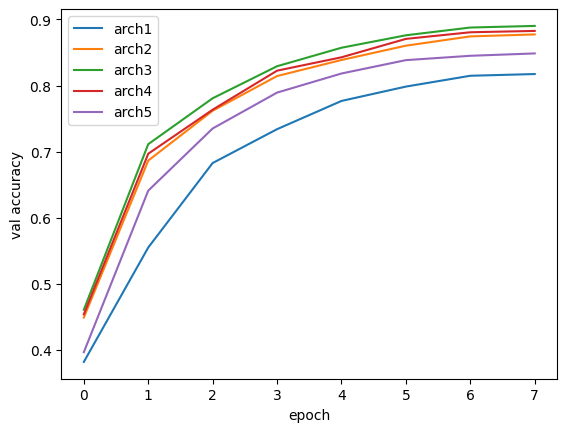

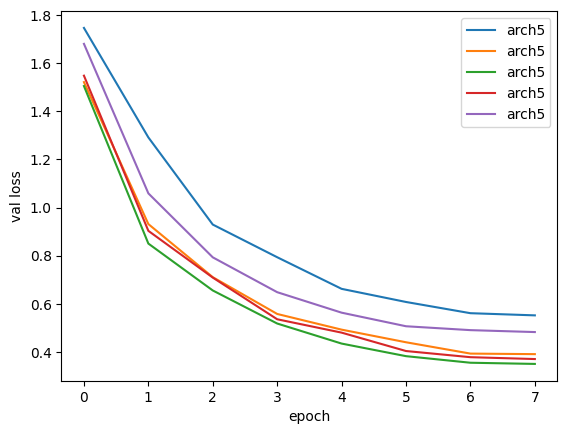

In [79]:
df1 = pd.DataFrame(results).sort_values("best_val_acc", ascending=False)
print(df1)
plot_results(histories, results, False)

## 5-fold CV on the best 2 architectures

In [18]:
results_cv = []
histories_cv = []

top2_names = df1["arch"].head(2).tolist()
top2_cfgs = [c for c in cfg if c.name in top2_names]
top2_names

for cf in top2_cfgs:
    for fold_id in range(cf.k_folds):
        res, hist = train_one_fold(fold_id, cf)
        res["arch"] = cf.name
        res["fold"] = fold_id
        results_cv.append(res)
        histories_cv.append(hist)

df2 = pd.DataFrame(results_cv)
df2

[Cfg(name='arch3', img_size=96, min_box_size=8, batch_size=128, num_workers=8, val_frac=0.1, patch_size=8, embed_dim=256, depth=6, num_heads=4, mlp_ratio=4.0, drop=0.1, attn_drop=0.0, epochs=8, lr=0.0003, min_lr=1e-06, warmup_epochs=1, weight_decay=0.05, grad_clip=1.0, log_interval=50, val_interval=500, val_batches=30, k_folds=5, seed=1337, data_dir='./data/caltechfn', out_dir='./runs/vit_caltechfn'), Cfg(name='arch4', img_size=96, min_box_size=8, batch_size=128, num_workers=8, val_frac=0.1, patch_size=8, embed_dim=192, depth=10, num_heads=3, mlp_ratio=4.0, drop=0.1, attn_drop=0.0, epochs=8, lr=0.0003, min_lr=1e-06, warmup_epochs=1, weight_decay=0.05, grad_clip=1.0, log_interval=50, val_interval=500, val_batches=30, k_folds=5, seed=1337, data_dir='./data/caltechfn', out_dir='./runs/vit_caltechfn')]

=== Fold 1/5 ===
Train crops: 163780 | Val crops: 40946 | Params: 4,828,426
epoch 01 | step 000050/10232 | loss 2.3385 | lr 1.17e-05
epoch 01 | step 000100/10232 | loss 2.2609 | lr 2.35e-05

/tmp/ipykernel_3416459/1958671625.py:120: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location=device)



=== Fold 2/5 ===
Train crops: 163781 | Val crops: 40945 | Params: 4,828,426
epoch 01 | step 000050/10232 | loss 2.3405 | lr 1.17e-05
epoch 01 | step 000100/10232 | loss 2.2941 | lr 2.35e-05
epoch 01 | step 000150/10232 | loss 2.2457 | lr 3.52e-05
epoch 01 | step 000200/10232 | loss 2.2370 | lr 4.69e-05
epoch 01 | step 000250/10232 | loss 2.1756 | lr 5.86e-05
epoch 01 | step 000300/10232 | loss 2.2364 | lr 7.04e-05
epoch 01 | step 000350/10232 | loss 2.1799 | lr 8.21e-05
epoch 01 | step 000400/10232 | loss 2.0820 | lr 9.38e-05
epoch 01 | step 000450/10232 | loss 2.1032 | lr 1.06e-04
epoch 01 | step 000500/10232 | loss 2.0465 | lr 1.17e-04
  [val@step] loss 2.0520 | acc 0.2646
  [CKPT] saved best → runs/vit_caltechfn/arch3/fold_1/best.pt (val_acc=0.2646)
epoch 01 | step 000550/10232 | loss 2.0095 | lr 1.29e-04
epoch 01 | step 000600/10232 | loss 1.9242 | lr 1.41e-04
epoch 01 | step 000650/10232 | loss 2.0373 | lr 1.52e-04
epoch 01 | step 000700/10232 | loss 2.0196 | lr 1.64e-04
epoch 01

,fold,best_val_acc,final_val_loss,final_val_acc,ckpt_path,arch
0,0,0.891667,0.355250,0.889953,runs/vit_caltechfn/arch3/fold_0/best.pt,arch3
1,1,0.902723,0.321744,0.902723,runs/vit_caltechfn/arch3/fold_1/best.pt,arch3
2,2,0.908073,0.330047,0.898596,runs/vit_caltechfn/arch3/fold_2/best.pt,arch3
3,3,0.906771,0.337861,0.898229,runs/vit_caltechfn/arch3/fold_3/best.pt,arch3
4,4,0.889559,0.356256,0.889559,runs/vit_caltechfn/arch3/fold_4/best.pt,arch3
5,0,0.895312,0.361628,0.888292,runs/vit_caltechfn/arch4/fold_0/best.pt,arch4
6,1,0.891415,0.350906,0.891415,runs/vit_caltechfn/arch4/fold_1/best.pt,arch4
7,2,0.901563,0.351080,0.889657,runs/vit_caltechfn/arch4/fold_2/best.pt,arch4
8,3,0.890512,0.352661,0.890512,runs/vit_caltechfn/arch4/fold_3/best.pt,arch4
9,4,0.891782,0.347208,0.891782,runs/vit_caltechfn/arch4/fold_4/best.pt,arch4


## Plot 5-fold CV results

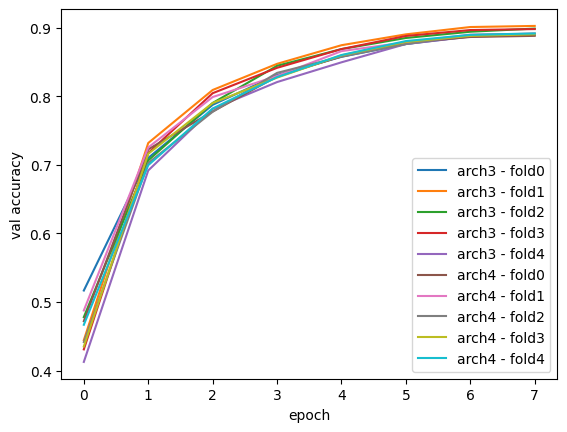

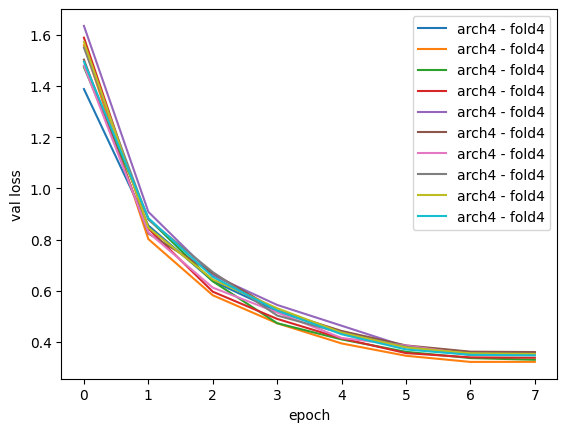

In [80]:
plot_results(histories_cv, results_cv, True)

## Extract best architecture from CV results

In [61]:
summary = (df2.groupby("arch")
             .agg(mean_val_acc=("final_val_acc","mean"),
                  std_val_acc=("final_val_acc","std"))
             .sort_values("mean_val_acc", ascending=False))
print(summary)

best_arch = summary.index[0]
best_cfg = [c for c in top2_cfgs if c.name == best_arch][0]
print("\nBest architecture: " + best_arch)

       mean_val_acc  std_val_acc
arch                            
arch3      0.895812     0.005805
arch4      0.890331     0.001408

Best architecture: arch3


## Train best arch on full train set and eval on test set

In [66]:
final_result = train_full_and_test(best_cfg)
final_result


Training final model on full train set | arch3 | train crops=204726
epoch 01 | step 000050/12792 | loss 2.3038 | lr 9.38e-06
epoch 01 | step 000100/12792 | loss 2.3078 | lr 1.88e-05
epoch 01 | step 000150/12792 | loss 2.2997 | lr 2.81e-05
epoch 01 | step 000200/12792 | loss 2.2531 | lr 3.75e-05
epoch 01 | step 000250/12792 | loss 2.2222 | lr 4.69e-05
epoch 01 | step 000300/12792 | loss 2.2175 | lr 5.63e-05
epoch 01 | step 000350/12792 | loss 2.1748 | lr 6.57e-05
epoch 01 | step 000400/12792 | loss 2.1831 | lr 7.50e-05
epoch 01 | step 000450/12792 | loss 2.0477 | lr 8.44e-05
epoch 01 | step 000500/12792 | loss 2.0661 | lr 9.38e-05
epoch 01 | step 000550/12792 | loss 2.1027 | lr 1.03e-04
epoch 01 | step 000600/12792 | loss 2.0364 | lr 1.13e-04
epoch 01 | step 000650/12792 | loss 1.8510 | lr 1.22e-04
epoch 01 | step 000700/12792 | loss 2.0475 | lr 1.31e-04
epoch 01 | step 000750/12792 | loss 1.9115 | lr 1.41e-04
epoch 01 | step 000800/12792 | loss 1.8646 | lr 1.50e-04
epoch 01 | step 000

({'arch': 'arch3',
  'test_loss': 0.3169587130953626,
  'test_acc': 0.9023413070669168,
  'ckpt': 'runs/vit_caltechfn/stage3_final/arch3/final.pt'},
 {'epoch': [1, 2, 3, 4, 5, 6, 7, 8],
  'epoch_train_loss': [1.9095329979645452,
   1.05346776944835,
   0.707861357233985,
   0.5490268444254519,
   0.4418470582192655,
   0.3605918919503353,
   0.3017353585748243,
   0.2672892070193079],
  'epoch_last_lr': [0.0003,
   0.0002852130465880762,
   0.00024374452804096946,
   0.000183807787146259,
   0.00011727403051403008,
   5.7321084628271644e-05,
   1.5823365696287096e-05,
   1.0000058886796922e-06]})

## Plot final results

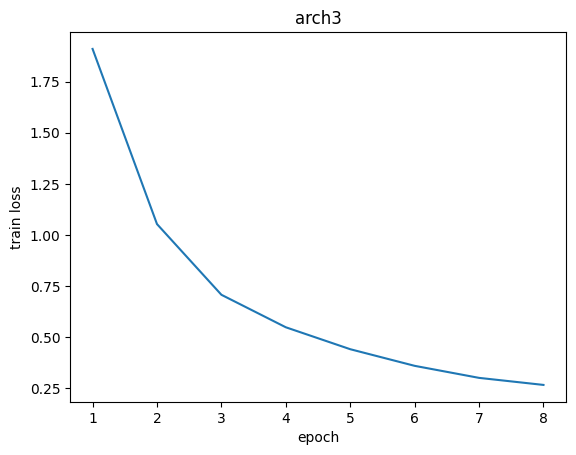

In [73]:
plot_final_train_results(final_result[1], title=final_result[0]['arch'])

## Visualize a batch of cropped digits

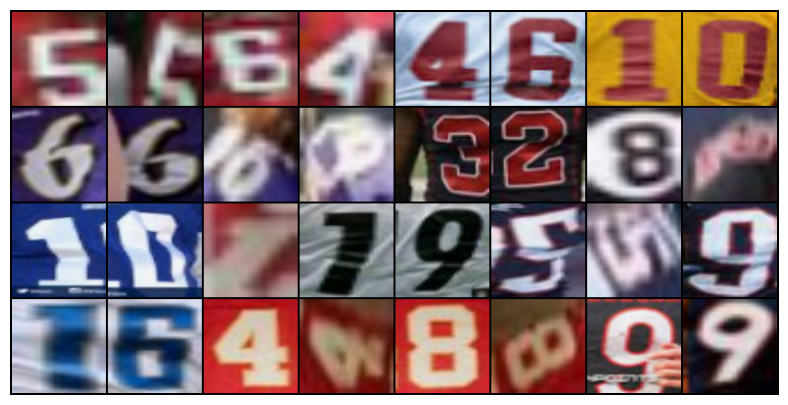

In [41]:
def denorm(x):
    mean = torch.tensor(MEAN).view(1,3,1,1)
    std  = torch.tensor(STD).view(1,3,1,1)
    return x * std + mean

tmp_loader = DataLoader(Subset(CaltechFN(train_root, "train.json", transform=test_tfms, min_box_size=cfg[2].min_box_size), list(range(128))),
                        batch_size=32, shuffle=False)

xb, yb = next(iter(tmp_loader))
grid = torchvision.utils.make_grid(denorm(xb[:32]), nrow=8).clamp(0,1)
plt.figure(figsize=(12,5))
plt.imshow(grid.permute(1,2,0))
plt.axis("off")
plt.show()